In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from disparity import disparity_filter, calc_alpha_ptile, cut_graph, describe_graph

In [2]:
tky = pd.read_csv('data/dataset_TSMC2014_TKY.csv', parse_dates = ['utcTimestamp'])
tky['timestamp'] = tky.utcTimestamp + tky.timezoneOffset.apply(lambda t: pd.Timedelta(t, unit = 'min'))

In [3]:
print("The dataset has %s rows spread out over:" % len(tky))
print("%s users" % len(tky.userId.unique()))
print("%s venues" % len(tky.venueId.unique()))
print("%s venue categories" % len(tky.venueCategoryId.unique()))

The dataset has 573703 rows spread out over:
2293 users
61858 venues
385 venue categories


Number of tourists using app:  7


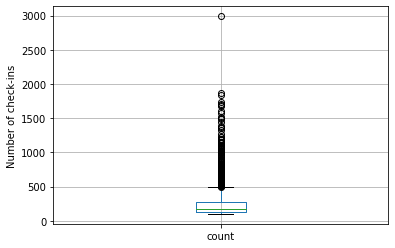

In [4]:
diff = tky.groupby('userId').timestamp.aggregate(['min', 'max'])
tourists = (diff['max'] - diff['min']) < pd.Timedelta(31, unit='d')
num_of_tourists = sum(tourists)

print("Number of tourists using app: ", num_of_tourists)

tky = tky.drop(tourists[tourists].index)

ax = tky.groupby('userId').venueId.aggregate(['count']).boxplot()
ax.set_ylabel('Number of check-ins')

plt.savefig('check-ins_box.png')

In [5]:
userpaths = {}
userpaths_cat = {}
num_of_trips = 0

userpaths_we = {}
userpaths_cat_we = {}
num_of_trips_we = 0

grouped = tky.groupby('userId')
for user, data in grouped:
    data = data.sort_values(by = 'timestamp')
    
    userpaths[user] = []
    userpaths_cat[user] = []
    userpaths_we[user] = []
    userpaths_cat_we[user] = []

    for i in range(len(data.index) - 1):
        if data.timestamp.iloc[i+1] - data.timestamp.iloc[i] < pd.Timedelta(4, unit = 'h'):
            if data.venueId.iloc[i] != data.venueId.iloc[i+1]:
                if data.timestamp.iloc[i].weekday() < 5:
                    userpaths[user].append((data.venueId.iloc[i], data.venueId.iloc[i+1]))
                    userpaths_cat[user].append((data.venueCategory.iloc[i], data.venueCategory.iloc[i+1]))
                    num_of_trips += 1

                else:
                    userpaths_we[user].append((data.venueId.iloc[i], data.venueId.iloc[i+1]))
                    userpaths_cat_we[user].append((data.venueCategory.iloc[i], data.venueCategory.iloc[i+1]))            
                    num_of_trips_we += 1
    
print("Number of linked trips: ", num_of_trips + num_of_trips_we)

[('4f0fd5a8e4b03856eeb6c8cb', '4b83b207f964a5202c0d31e3'), ('4b83b207f964a5202c0d31e3', '4ea281c302d529c116a57755'), ('4f50329ee4b07af68d5145d4', '4d9bdba7cbc96ea83b5cf525'), ('4d9bdba7cbc96ea83b5cf525', '4f6530a0e4b04d4b1657f0da'), ('4f6530a0e4b04d4b1657f0da', '4cb95cb7d78f468851eeb573'), ('4cb95cb7d78f468851eeb573', '4f0fd5a8e4b03856eeb6c8cb'), ('4f0fd5a8e4b03856eeb6c8cb', '4ea281c302d529c116a57755'), ('4ea281c302d529c116a57755', '4da5175043a1de92fac34770'), ('4da5175043a1de92fac34770', '4caae6a814c33704a3c1e53b'), ('4caae6a814c33704a3c1e53b', '4f694d11e4b0cb40746676bf'), ('4f694d11e4b0cb40746676bf', '4d2827c0ec272d43a14e354c'), ('4d2827c0ec272d43a14e354c', '4cc5b9f3c844721eaec9f001'), ('4cc5b9f3c844721eaec9f001', '4c1bfe77b9f876b09b347b46'), ('4c1bfe77b9f876b09b347b46', '4ed7b2d60aaf7ccfdc6318cd'), ('4ed7b2d60aaf7ccfdc6318cd', '4b5c0eb9f964a520b12229e3'), ('4b5c0eb9f964a520b12229e3', '4dce6f49fa7664b7c6a6fd3e'), ('4dce6f49fa7664b7c6a6fd3e', '4b5bc0daf964a5203f1429e3'), ('4b5bc0daf96

In [6]:
from geopy.distance import distance

def set_dist(g):
    global tky
    venues = tky.groupby('venueId')[['latitude', 'longitude', 'venueCategory']].agg('first')

    for u, v in g.edges:
        point1 = (venues.loc[u].latitude, venues.loc[u].longitude)
        point2 = (venues.loc[v].latitude, venues.loc[v].longitude)

        g[u][v]['dist'] = distance(point1, point2).km

full_g = nx.DiGraph()
for _, edges in userpaths.items():
    for edge in edges:
        if full_g.has_edge(edge[0], edge[1]):
            full_g[edge[0]][edge[1]]['weight'] += 1
        else:
            full_g.add_edge(edge[0], edge[1], weight = 1)
            
set_dist(full_g)
        
cat_g = nx.DiGraph()
for _, edges in userpaths_cat.items():
    for edge in edges:
        if cat_g.has_edge(edge[0], edge[1]):
            cat_g[edge[0]][edge[1]]['weight'] += 1
        else:
            cat_g.add_edge(edge[0], edge[1], weight = 1)
            
full_g_we = nx.DiGraph()
for _, edges in userpaths_we.items():
    for edge in edges:
        if full_g_we.has_edge(edge[0], edge[1]):
            full_g_we[edge[0]][edge[1]]['weight'] += 1
        else:
            full_g_we.add_edge(edge[0], edge[1], weight = 1)
           
set_dist(full_g_we)

cat_g_we = nx.DiGraph()
for _, edges in userpaths_cat_we.items():
    for edge in edges:
        if cat_g_we.has_edge(edge[0], edge[1]):
            cat_g_we[edge[0]][edge[1]]['weight'] += 1
        else:
            cat_g_we.add_edge(edge[0], edge[1], weight = 1)
            

In [7]:
print("#### Statistics for the weekday category graph:")
print("Number of trips recorded:", num_of_trips)

print("Number of nodes: %s" % len(cat_g))
print("Number of edges: %s\n" % len(cat_g.edges))

wk_comp = list(nx.weakly_connected_components(cat_g))
print("Number of weakly connected components: ", len(wk_comp))
print("First 20 weakly connected components: %s" % sorted([len(s) for s in wk_comp], reverse=True)[:20])

str_comp = list(nx.strongly_connected_components(cat_g))
print("Number of strongly connected components: ", len(str_comp))
print("First 20 strongly connected components: %s\n" % sorted([len(s) for s in str_comp], reverse=True)[:20])

print("#### Statistics for the weekend category graph:")
print("Number of trips recorded:", num_of_trips_we)

print("Number of nodes: %s" % len(cat_g_we))
print("Number of edges: %s\n" % len(cat_g_we.edges))

wk_comp_we = list(nx.weakly_connected_components(cat_g_we))
print("Number of weakly connected components: ", len(wk_comp_we))
print("First 20 weakly connected components: %s" % sorted([len(s) for s in wk_comp_we], reverse=True)[:20])

str_comp_we = list(nx.strongly_connected_components(cat_g_we))
print("Number of strongly connected components: ", len(str_comp_we))
print("First 20 strongly connected components: %s\n" % sorted([len(s) for s in str_comp_we], reverse=True)[:20])

#### Statistics for the weekday category graph:
Number of trips recorded: 208504
Number of nodes: 240
Number of edges: 10419

Number of weakly connected components:  1
First 20 weakly connected components: [240]
Number of strongly connected components:  7
First 20 strongly connected components: [234, 1, 1, 1, 1, 1, 1]

#### Statistics for the weekend category graph:
Number of trips recorded: 108811
Number of nodes: 234
Number of edges: 9784

Number of weakly connected components:  1
First 20 weakly connected components: [234]
Number of strongly connected components:  8
First 20 strongly connected components: [227, 1, 1, 1, 1, 1, 1, 1]



In [8]:
in_cen = sorted(nx.in_degree_centrality(cat_g).items(), key=lambda node: node[1], reverse=True)
in_cen_we = sorted(nx.in_degree_centrality(cat_g_we).items(), key=lambda node: node[1], reverse=True)

out_cen = sorted(nx.out_degree_centrality(cat_g).items(), key=lambda node: node[1], reverse=True)
out_cen_we = sorted(nx.out_degree_centrality(cat_g_we).items(), key=lambda node: node[1], reverse=True)

for i in range(5):
    print("|{0} ({1:.2f})".format(in_cen[i][0], in_cen[i][1]), end = '')
    print("|{0} ({1:.2f})".format(out_cen[i][0], out_cen[i][1]), end = '')
    print("|{0} ({1:.2f})".format(in_cen_we[i][0], in_cen_we[i][1]), end = '')
    print("|{0} ({1:.2f})".format(out_cen_we[i][0], out_cen_we[i][1]), end = '')
    print('|')

|Train Station (0.87)|Train Station (0.90)|Train Station (0.85)|Train Station (0.88)|
|Subway (0.72)|Subway (0.73)|Bar (0.71)|Subway (0.70)|
|Bar (0.66)|Mall (0.67)|Food & Drink Shop (0.69)|Mall (0.64)|
|Japanese Restaurant (0.65)|Japanese Restaurant (0.64)|Subway (0.63)|Ramen /  Noodle House (0.62)|
|Ramen /  Noodle House (0.65)|Food & Drink Shop (0.64)|Café (0.63)|Café (0.61)|


In [9]:
def weighted_degree_centrality(graph, alpha):
    in_wghts = {}
    out_wghts = {}
    for oute, ine, weight in graph.edges.data('weight'):
        out_wghts.setdefault(oute, 0)
        out_wghts[oute] += weight
        
        in_wghts.setdefault(ine, 0)
        in_wghts[ine] += weight
    
    degs = {}
    for node in graph:
        if (node in in_wghts.keys()):
            ind = graph.in_degree(node) * (in_wghts[node] / float(graph.in_degree(node))) ** alpha
        else:
            ind = 0
        if (node in out_wghts.keys()):
            outd = graph.out_degree(node) * (out_wghts[node] / float(graph.out_degree(node))) ** alpha
        else:
            outd = 0
            
        degs[node] = (outd, ind)
        
    return degs
    

In [10]:
centr = weighted_degree_centrality(cat_g, 0.8)
centr_we = weighted_degree_centrality(cat_g_we, 0.8)

in_centr = sorted(centr.items(), key=lambda item: item[1][1], reverse=True)
out_centr = sorted(centr.items(), key=lambda item: item[1][0], reverse=True)
in_centr_we = sorted(centr_we.items(), key=lambda item: item[1][1], reverse=True)
out_centr_we = sorted(centr_we.items(), key=lambda item: item[1][0], reverse=True)

for i in range(2,7):
    print("|{0} ({1:.2f})".format(in_centr[i][0], in_centr[i][1][1]), end = '')
    # print("|{0} ({1:.2f})".format(out_centr[i][0], out_centr[i][1][0]), end = '')
    print("|{0} ({1:.2f})".format(in_centr_we[i][0], in_centr_we[i][1][1]), end = '')
    # print("|{0} ({1:.2f})".format(out_centr_we[i][0], out_centr_we[i][1][0]), end = '')
    print('|')

|Convenience Store (3371.22)|Electronics Store (1835.14)|
|Food & Drink Shop (2581.27)|Food & Drink Shop (1707.78)|
|Ramen /  Noodle House (2338.98)|Bar (1669.24)|
|Bar (2257.48)|Mall (1561.11)|
|Electronics Store (2203.10)|Convenience Store (1405.65)|


In [11]:
for u, v in cat_g.edges:
    cat_g[u][v]['dist'] = 1 / cat_g[u][v]['weight']
for u, v in cat_g_we.edges:
    cat_g_we[u][v]['dist'] = 1 / cat_g_we[u][v]['weight']


In [12]:
betw = sorted(nx.betweenness_centrality(cat_g, weight='dist').items(), key=lambda node: node[1], reverse=True)
betw_we = sorted(nx.betweenness_centrality(cat_g_we, weight='dist').items(), key=lambda node: node[1], reverse=True)

for i in range(5):
    print("|{0} ({1:.3f})".format(betw[i][0], betw[i][1]), end='')
    print("|{0} ({1:.3f})".format(betw_we[i][0], betw_we[i][1]), end='')
    print('|')

|Train Station (0.961)|Train Station (0.957)|
|Subway (0.076)|Food & Drink Shop (0.062)|
|Convenience Store (0.037)|Bar (0.042)|
|College Academic Building (0.033)|Electronics Store (0.038)|
|Bar (0.032)|Subway (0.037)|


In [13]:
def normalize_weights(g):
    max_weight = max([weight for _, _, weight in g.edges.data('weight')])
    for u, v in g.edges:
        g[u][v]['weight_norm'] = g[u][v]['weight'] / max_weight
    
normalize_weights(full_g)
normalize_weights(full_g_we)

In [14]:
# def backbone(g):
#     tmp = g.copy()
#     describe_graph(tmp)
#     alpha_measures = disparity_filter(tmp)
#     quantiles, num_quant = calc_alpha_ptile(alpha_measures, 20)
#     alpha_cutoff = quantiles[round(num_quant * 0.91)]
#     cut_graph(tmp, alpha_cutoff, 2)
# 
#     describe_graph(tmp)
#     return tmp
# 
# full_g_b = backbone(full_g)
# full_g_we_b = backbone(full_g_we)
# 
# nx.readwrite.write_weighted_edgelist(full_g_b, 'full_g_b.edges')
# nx.readwrite.write_weighted_edgelist(full_g_we_b, 'full_g_we_b.edges')
full_g_b = nx.readwrite.read_weighted_edgelist('full_g_b.edges')
full_g_we_b = nx.readwrite.read_weighted_edgelist('full_g_we_b.edges')

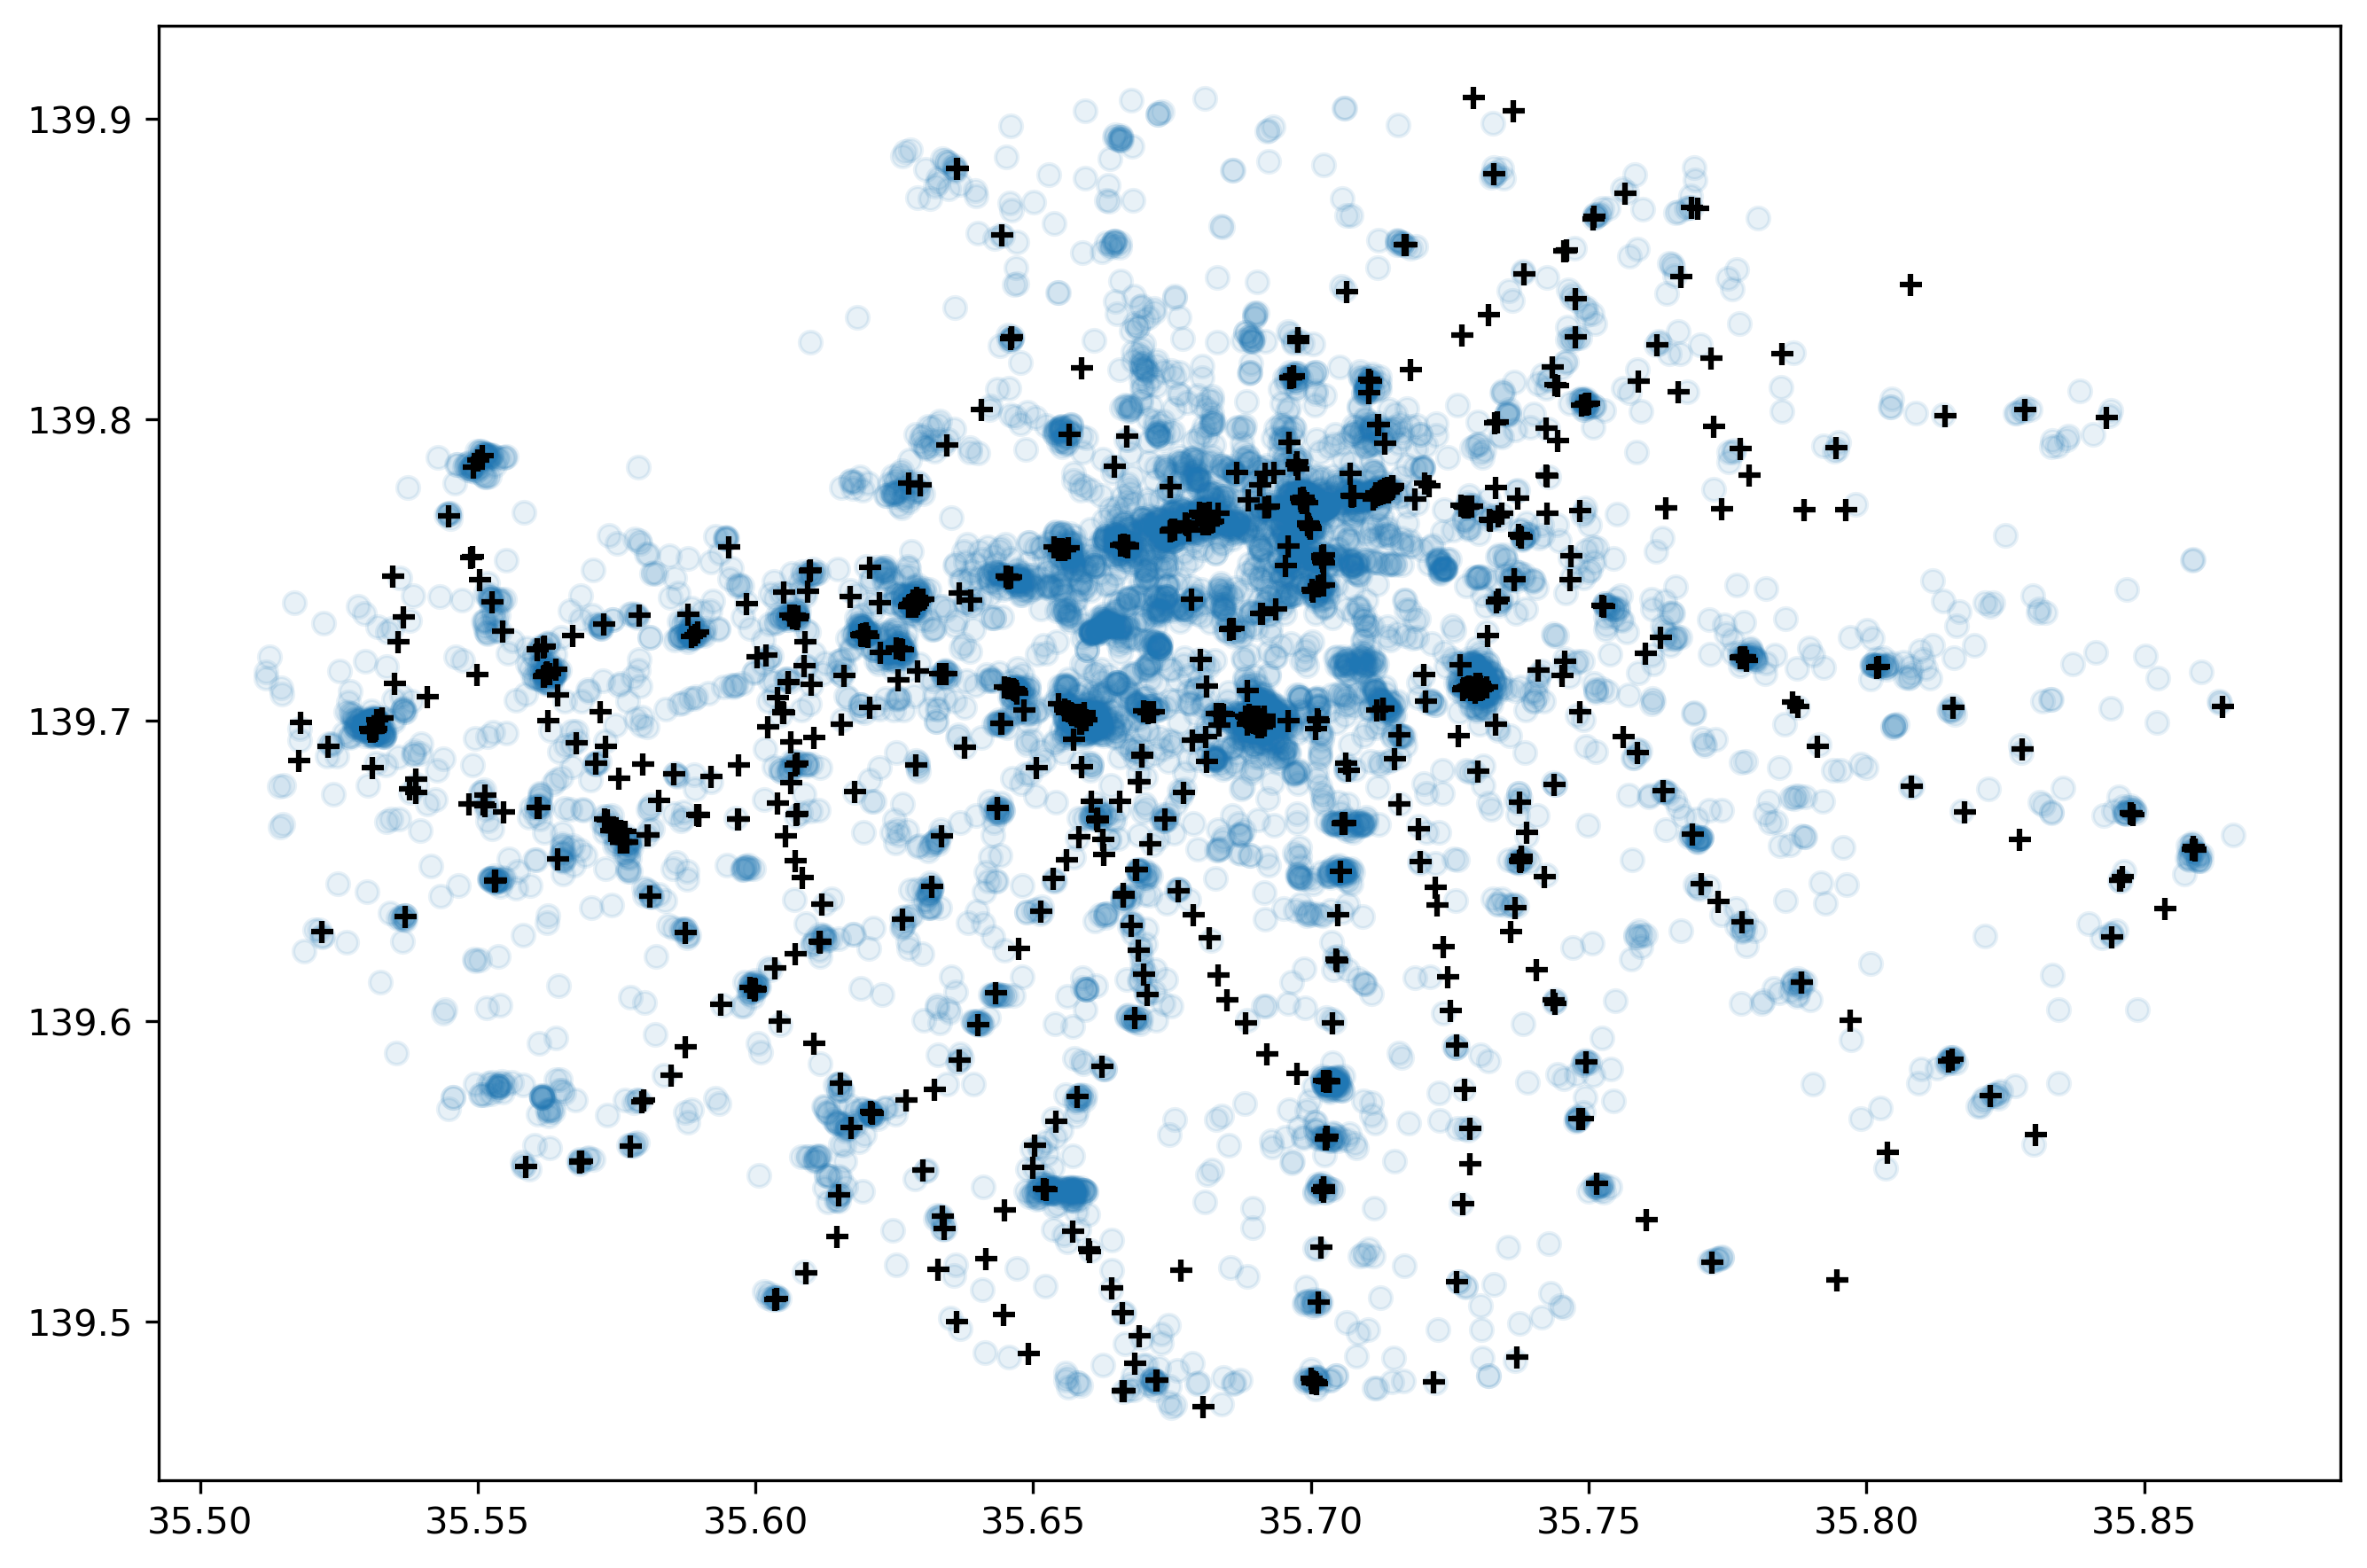

In [15]:
points = tky[tky.venueId.apply(lambda id: id in full_g_b.nodes)].groupby('venueId')[['latitude', 'longitude', 'venueCategory']].agg('first')
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6), dpi = 300)
ax = plt.scatter(points[points.venueCategory != 'Train Station'].latitude, points[points.venueCategory != 'Train Station'].longitude, alpha = 0.1)
plt.scatter(points[points.venueCategory == 'Train Station'].latitude, points[points.venueCategory == 'Train Station'].longitude, c='black', marker='+')
plt.tight_layout()
plt.savefig('full_g_map.png')


points = tky[tky.venueId.apply(lambda id: id in full_g_b.nodes)].groupby('venueId')[['latitude', 'longitude', 'venueCategory']].agg('first')

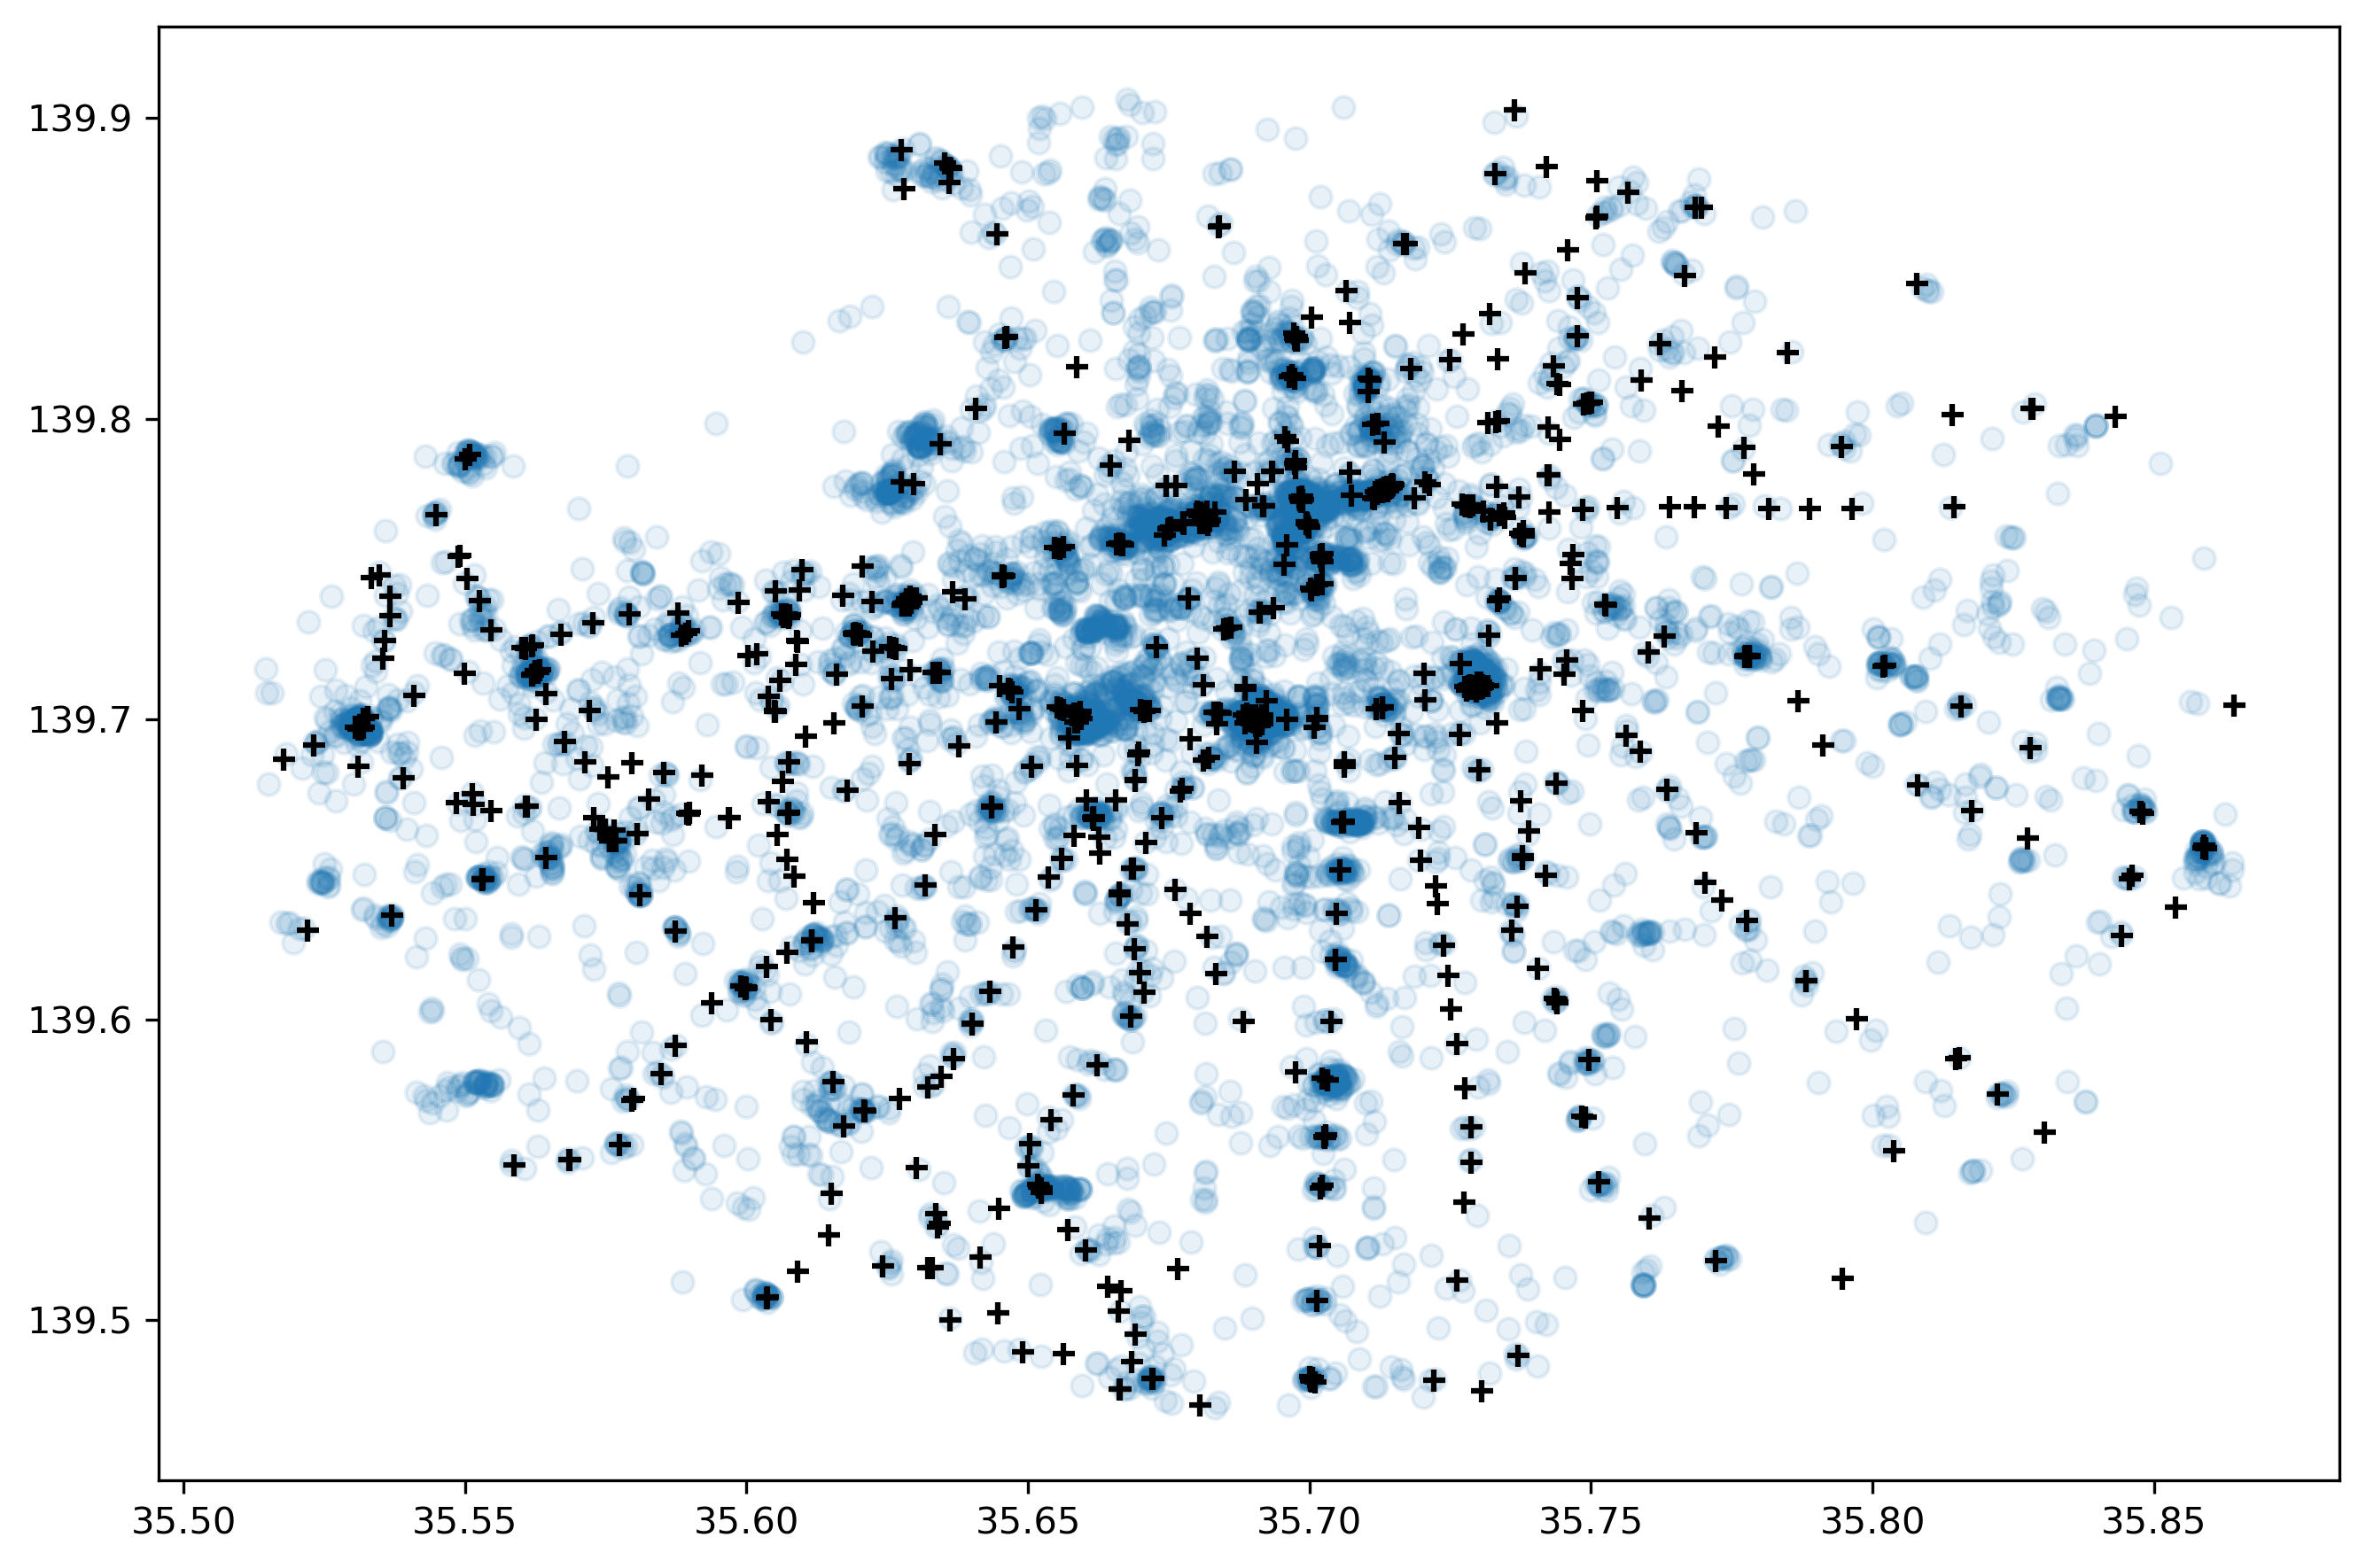

In [16]:
points_we = tky[tky.venueId.apply(lambda id: id in full_g_we_b.nodes)].groupby('venueId')[['latitude', 'longitude', 'venueCategory']].agg('first')
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6), dpi = 300)
ax = plt.scatter(points_we[points_we.venueCategory != 'Train Station'].latitude, points_we[points_we.venueCategory != 'Train Station'].longitude, alpha = 0.1)
plt.scatter(points_we[points_we.venueCategory == 'Train Station'].latitude, points_we[points_we.venueCategory == 'Train Station'].longitude, c='black', marker='+')
plt.tight_layout()
plt.savefig('full_g_we_map.png')


In [17]:
print(len(full_g.nodes))
print(len(full_g_we.nodes))
print(len(full_g_b.nodes))
print(len(full_g_we_b.nodes))

38474
30471
8631
8862


In [18]:
from geopy.distance import distance

def set_dist(g, data):
    for u, v in g.edges:
        point1 = (data.loc[u].latitude, data.loc[u].longitude)
        point2 = (data.loc[v].latitude, data.loc[v].longitude)

        g[u][v]['dist'] = distance(point1, point2).km
    
set_dist(full_g_b, points)
set_dist(full_g_we_b, points_we)

In [19]:
points['avg_dist'] = 0
points['clustering'] = 0
for u in points.index:
    tot = 0
    no = 0
    for neigh in full_g_b[u].values():
        tot += neigh['dist']
        no += 1
    
    points.loc[u, ['avg_dist']] = tot/float(no)
    points.loc[u, ['clustering']] = nx.clustering(full_g_b, u)
        
points_we['clustering'] = 0
points_we['avg_dist'] = 0
for u in points_we.index:
    tot = 0
    no = 0
    for neigh in full_g_we_b[u].values():
        tot += neigh['dist']
        no += 1
    
    points_we.loc[u, ['avg_dist']] = tot/float(no)
    points_we.loc[u, ['clustering']] = nx.clustering(full_g_we_b, u)


In [20]:
print(points.clustering.mean())
print(points_we.clustering.mean())

0.1463716671468204
0.14340927808565823


In [109]:
print("Diameter weekdays:")
comps = nx.connected_components(full_g_b)
nx.diameter(full_g_b.subgraph(max(comps, key=len)))

12

In [110]:
print("Diameter Weekends:")
comps = nx.connected_components(full_g_we_b)
nx.diameter(full_g_we_b.subgraph(max(comps, key=len)))

14

In [21]:
venues = tky.groupby('venueId')[['latitude', 'longitude', 'venueCategory']].agg('first')

In [22]:
print("Average clustering:")
print(nx.average_clustering(full_g_b))
print(nx.average_clustering(full_g_we_b))

Average clustering:
0.14637166714682048
0.14340927808565845


In [23]:
def eliminate_transport(points, graph):
    transport = ['Train Station', 'Bus Station', 'Subway', 'Light Rail', ]

    ind = points.venueCategory.apply(lambda c: c not in transport)
    tmp = graph.subgraph(points[ind].index)
    points['cmp'] = 0
    
    cmps = sorted(list(nx.connected_components(tmp)), key=len, reverse=True)
    
    for i in range(20):
        for node in cmps[i]:
            points.loc[node, 'cmp'] = i+1
            
    return tmp

tmp = eliminate_transport(points, full_g_b)

print("Number of nodes in the weekday graph:", len(full_g_b.nodes))
print("Number of nodes in the weekday graph without transport venues:", len(tmp.nodes))
print("Average clustering without transport venues:", nx.average_clustering(tmp))

tmp = tmp.subgraph(max([c for c in nx.connected_components(tmp)], key=len))

dists = 0
max_dist = 0
for node1 in tmp.nodes:
    nodedists = nx.single_source_shortest_path_length(tmp, node1)
    if max(nodedists.values()) > max_dist:
        max_dist = max(nodedists.values())
    dists += sum(nodedists.values())

print("Diameter without transport venues:", max_dist)
print("Average distance without transport venues:", dists / (len(tmp) * (len(tmp) - 1)))

Number of nodes in the weekday graph: 8631
Number of nodes in the weekday graph without transport venues: 7185
Average clustering without transport venues: 0.05358591115839622
Diameter without transport venues: 28
Average distance without transport venues: 7.092850974329293


In [ ]:
tmp = eliminate_transport(points_we, full_g_we_b)

print("Number of nodes in the weekend graph:", len(full_g_we_b.nodes))
print("Number of nodes in the weekend graph without transport venues:", len(tmp.nodes))
print("Average clustering without transport venues:", nx.average_clustering(tmp))

tmp = tmp.subgraph(max([c for c in nx.connected_components(tmp)], key=len))

dists = 0
max_dist = 0
for node1 in tmp.nodes:
    nodedists = nx.single_source_shortest_path_length(tmp, node1)
    if max(nodedists.values()) > max_dist:
        max_dist = max(nodedists.values())
    dists += sum(nodedists.values())

print("Diameter without transport venues:", max_dist)
print("Average distance without transport venues:", dists / (len(tmp) * (len(tmp) - 1)))

Number of nodes in the weekend graph: 8862
Number of nodes in the weekend graph without transport venues: 7451
Average clustering without transport venues: 0.07256380632627754


In [243]:
def create_net(paths, train_frac=0.8):
    from random import random
    tmp = nx.DiGraph()
    test = []

    for edges in paths.values():
        if len(edges) > 1:
            for i in range(len(edges) - 1):
                if edges[i][1] == edges[i+1][0]:
                    if random() < train_frac:
                        if tmp.has_edge(edges[i], edges[i+1]):
                            tmp[edges[i]][edges[i+1]]['weight'] += 1
                        else:
                            tmp.add_edge(edges[i], edges[i+1], weight=1)
                    else:
                        test.append((edges[i], edges[i+1]))
                        
    return tmp, test
  
twin_g, test = create_net(userpaths_cat)
twin_g_we, test_we = create_net(userpaths_cat_we)

In [245]:
def do_testing(g, test):
    correct = 0
    total = 0
    
    for edge in test:
        if edge[0] in g.nodes:
            if len(g[edge[0]].items()) > 0:
                pred = max(g[edge[0]].items(), key=lambda i: i[1]['weight'])[0]
                correct += pred == edge[1]
                total += 1
            else:
                total += 1
        else:
            total += 1
            
    return float(correct)/total    

print('Accuracies of the dual-venue models:')
print(do_testing(twin_g, test))
print(do_testing(twin_g_we, test_we))

0.41118993441306384
0.31991724656761333


In [241]:
twin_g, _ = create_net(userpaths_cat, 1)
twin_g_we, _ = create_net(userpaths_cat_we, 1)

transport_no = 0
total = 0
for u in twin_g.nodes:
    if len(twin_g[u].items()) > 0:
        total += 1
        transport_no += max(twin_g[u].items(), key=lambda i: i[1]['weight'])[0][1] == 'Train Station'

print('Fractions of nodes that go to Train Station venues:')
print(transport_no, total, float(transport_no)/total)

transport_no = 0
total = 0
for u in twin_g_we.nodes:
    if len(twin_g_we[u].items()) > 0:
        total += 1
        transport_no += max(twin_g_we[u].items(), key=lambda i: i[1]['weight'])[0][1] == 'Train Station'
        
print(transport_no, total, float(transport_no)/total)

transport_no = 0
total = 0
for u in cat_g.nodes:
    if len(cat_g[u].items()) > 0:
        total += 1
        transport_no += max(cat_g[u].items(), key=lambda i: i[1]['weight'])[0] == 'Train Station'
    
print(transport_no, total, float(transport_no)/total)

transport_no = 0
total = 0
for u in cat_g_we.nodes:
    if len(cat_g_we[u].items()) > 0:
        total += 1
        transport_no += max(cat_g_we[u].items(), key=lambda i: i[1]['weight'])[0] == 'Train Station'
        
print(transport_no, total, float(transport_no)/total)



2059 8353 0.2464982640967317
1787 7915 0.22577384712571066
144 237 0.6075949367088608
138 228 0.6052631578947368


In [253]:
def create_net_single(paths, train_frac=0.8):
    from random import random
    
    tmp = nx.DiGraph()
    test = []
    
    for edges in paths.values():
        for edge in edges:
            if random() < train_frac:
                if tmp.has_edge(edge[0], edge[1]):
                    tmp[edge[0]][edge[1]]['weight'] += 1
                else:
                    tmp.add_edge(edge[0], edge[1], weight=1)
            else:
                test.append(edge)
                
    return tmp, test
        
def test_single(g, test):
    correct = 0
    total = 0
    
    for u, v in test:
        total += 1
        
        if u in g.nodes:
            if len(g[u].items()) > 0:
                pred = max(g[u].items(), key=lambda i: i[1]['weight'])[0]
                correct += pred == v
                
    return correct / float(total)

print("Single venue model accuracies:")
single_g, single_test = create_net_single(userpaths)
single_g_we, single_test_we = create_net_single(userpaths_we)
print(test_single(single_g, single_test))
print(test_single(single_g_we, single_test_we))

0.1758567872869998
0.09876088258326039


In [297]:
def do_spread(g, node, no_users=100):
    nodes = []
    people = []
    g.nodes[node]['old_visit'] = no_users
    
    for neigh in g[node].items():
        flow = neigh[1]['weight'] / g.out_degree(node, 'weight') * g.nodes[node]['old_visit']
        if flow > 1:
            nodes.append(neigh[0])
            people.append(flow)
            g.nodes[neigh[0]]['new_visit'] = flow
            
    return nodes, people
    
nodes, people = do_spread(cat_g, 'Bar')

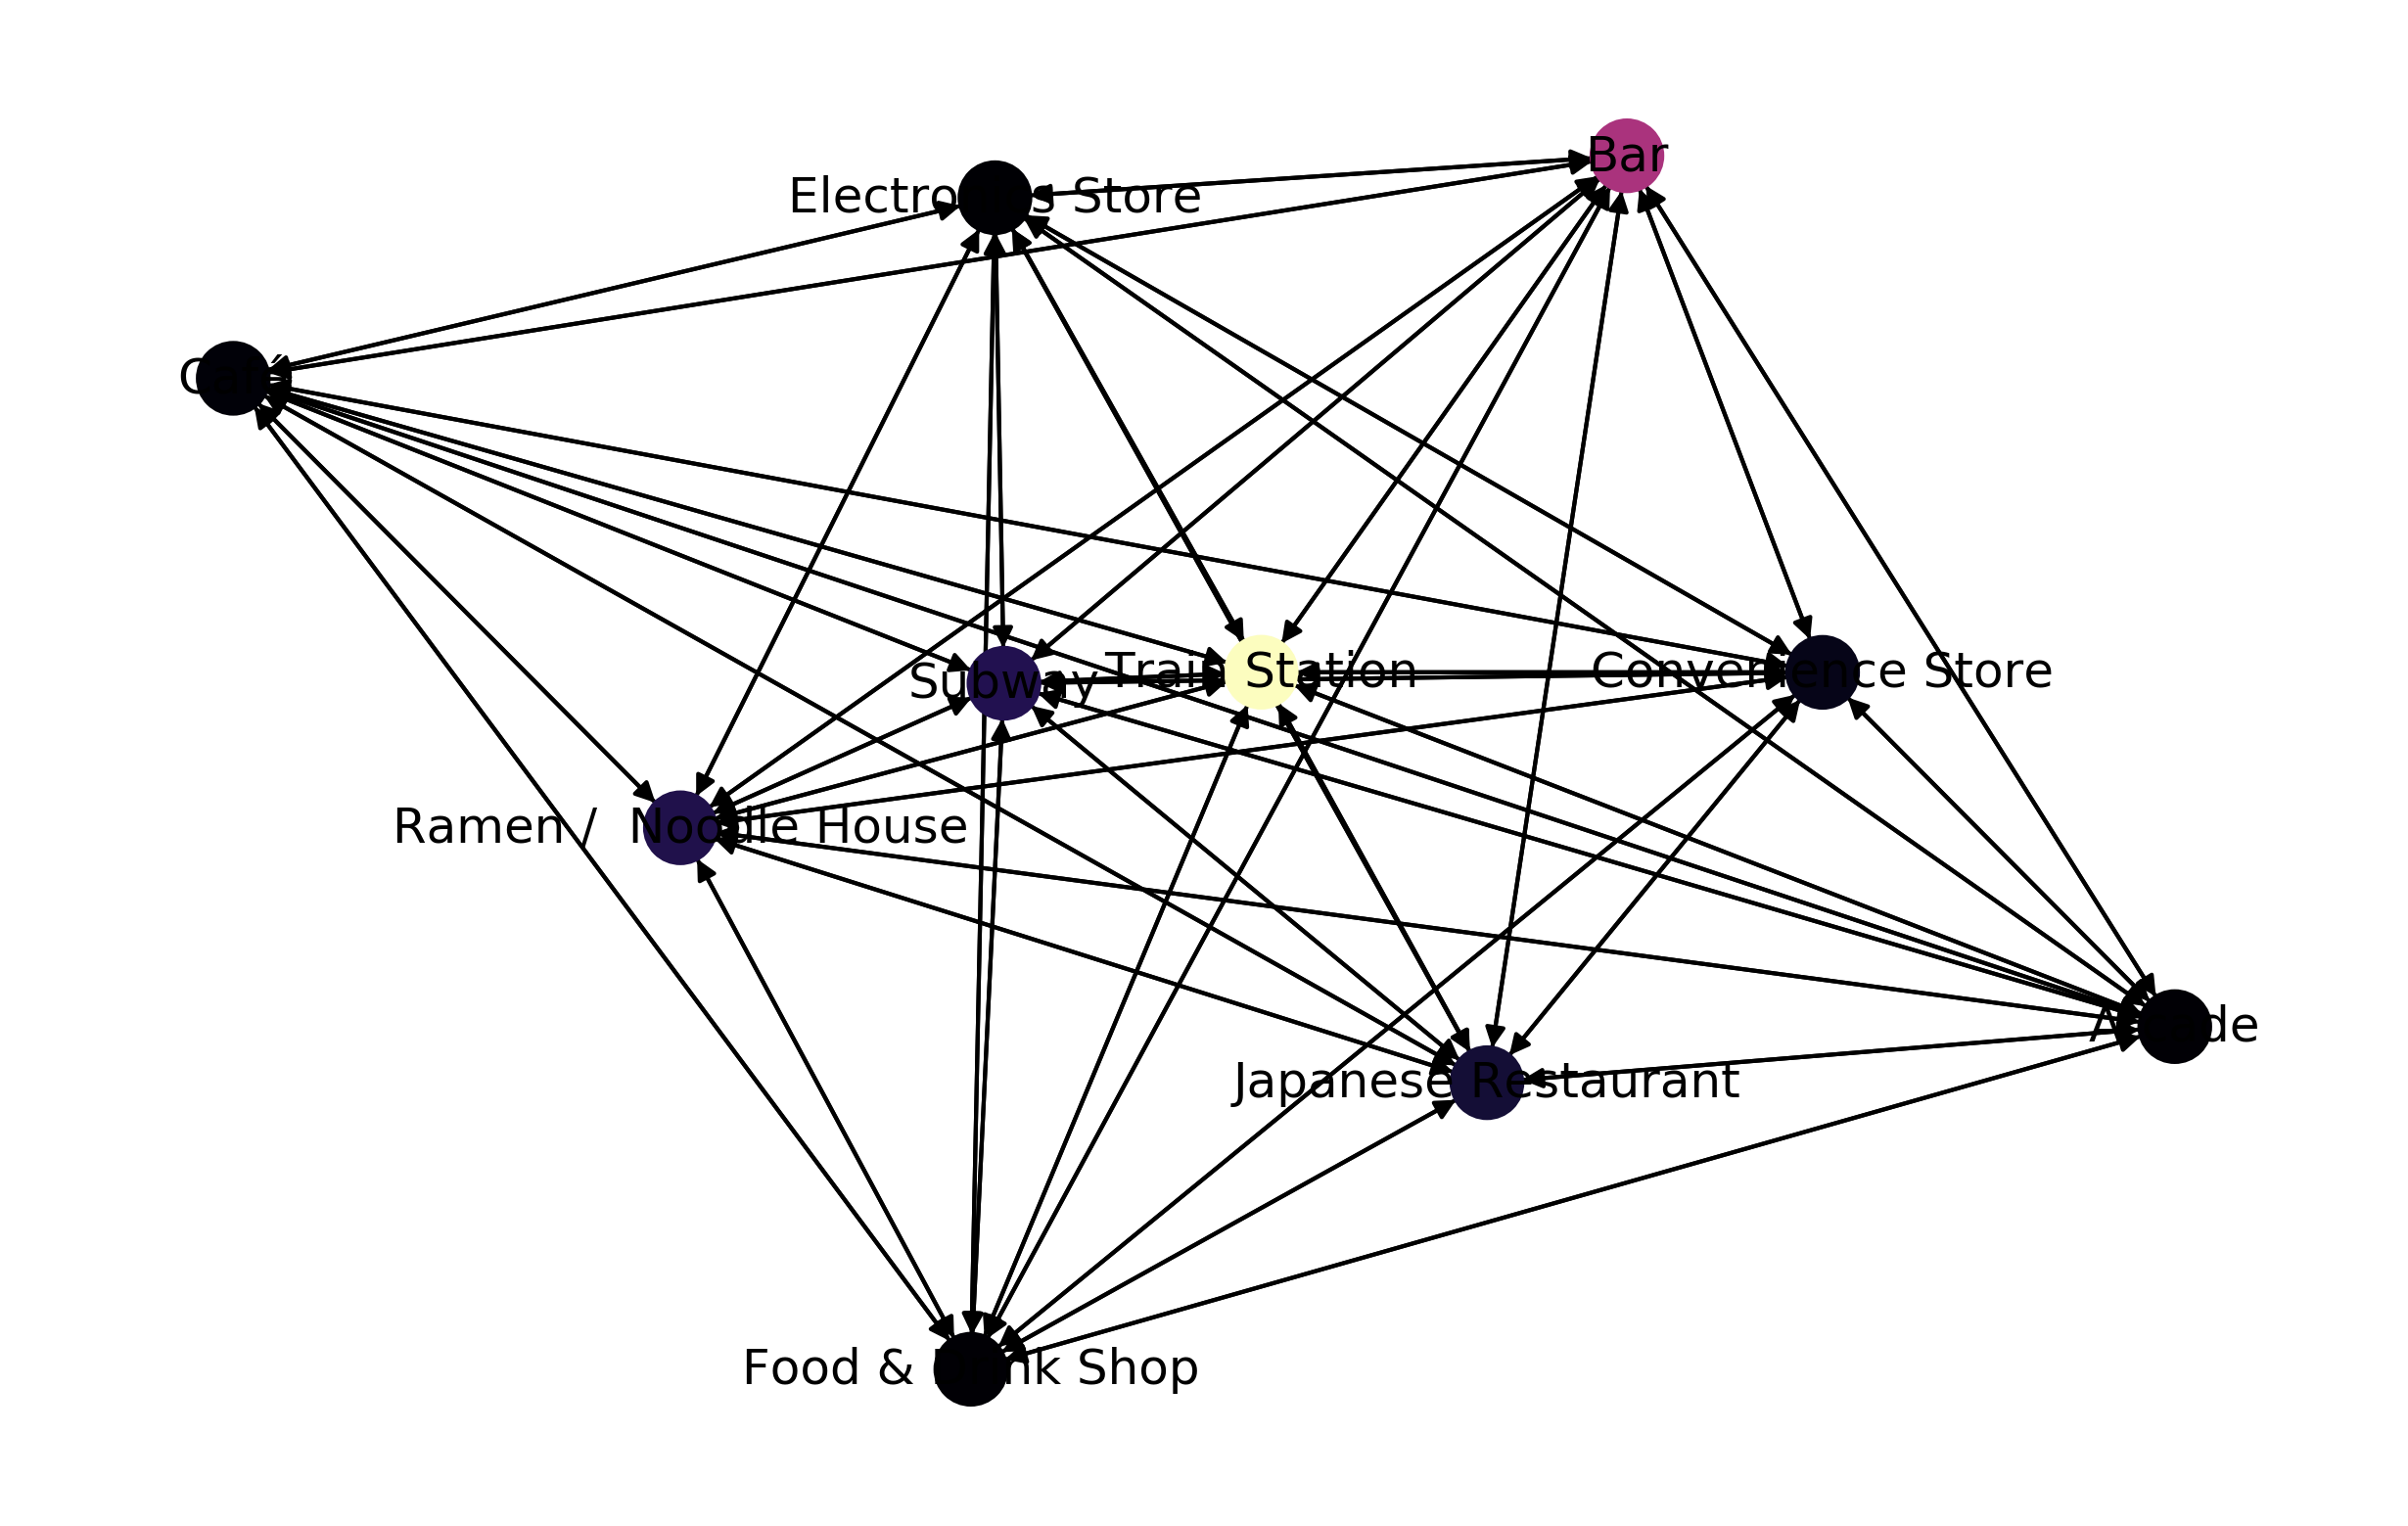

In [302]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=300)
nx.draw(cat_g.subgraph(nodes), nodelist=nodes, node_color=people, with_labels=True, cmap='magma')
plt.savefig('iter.png')

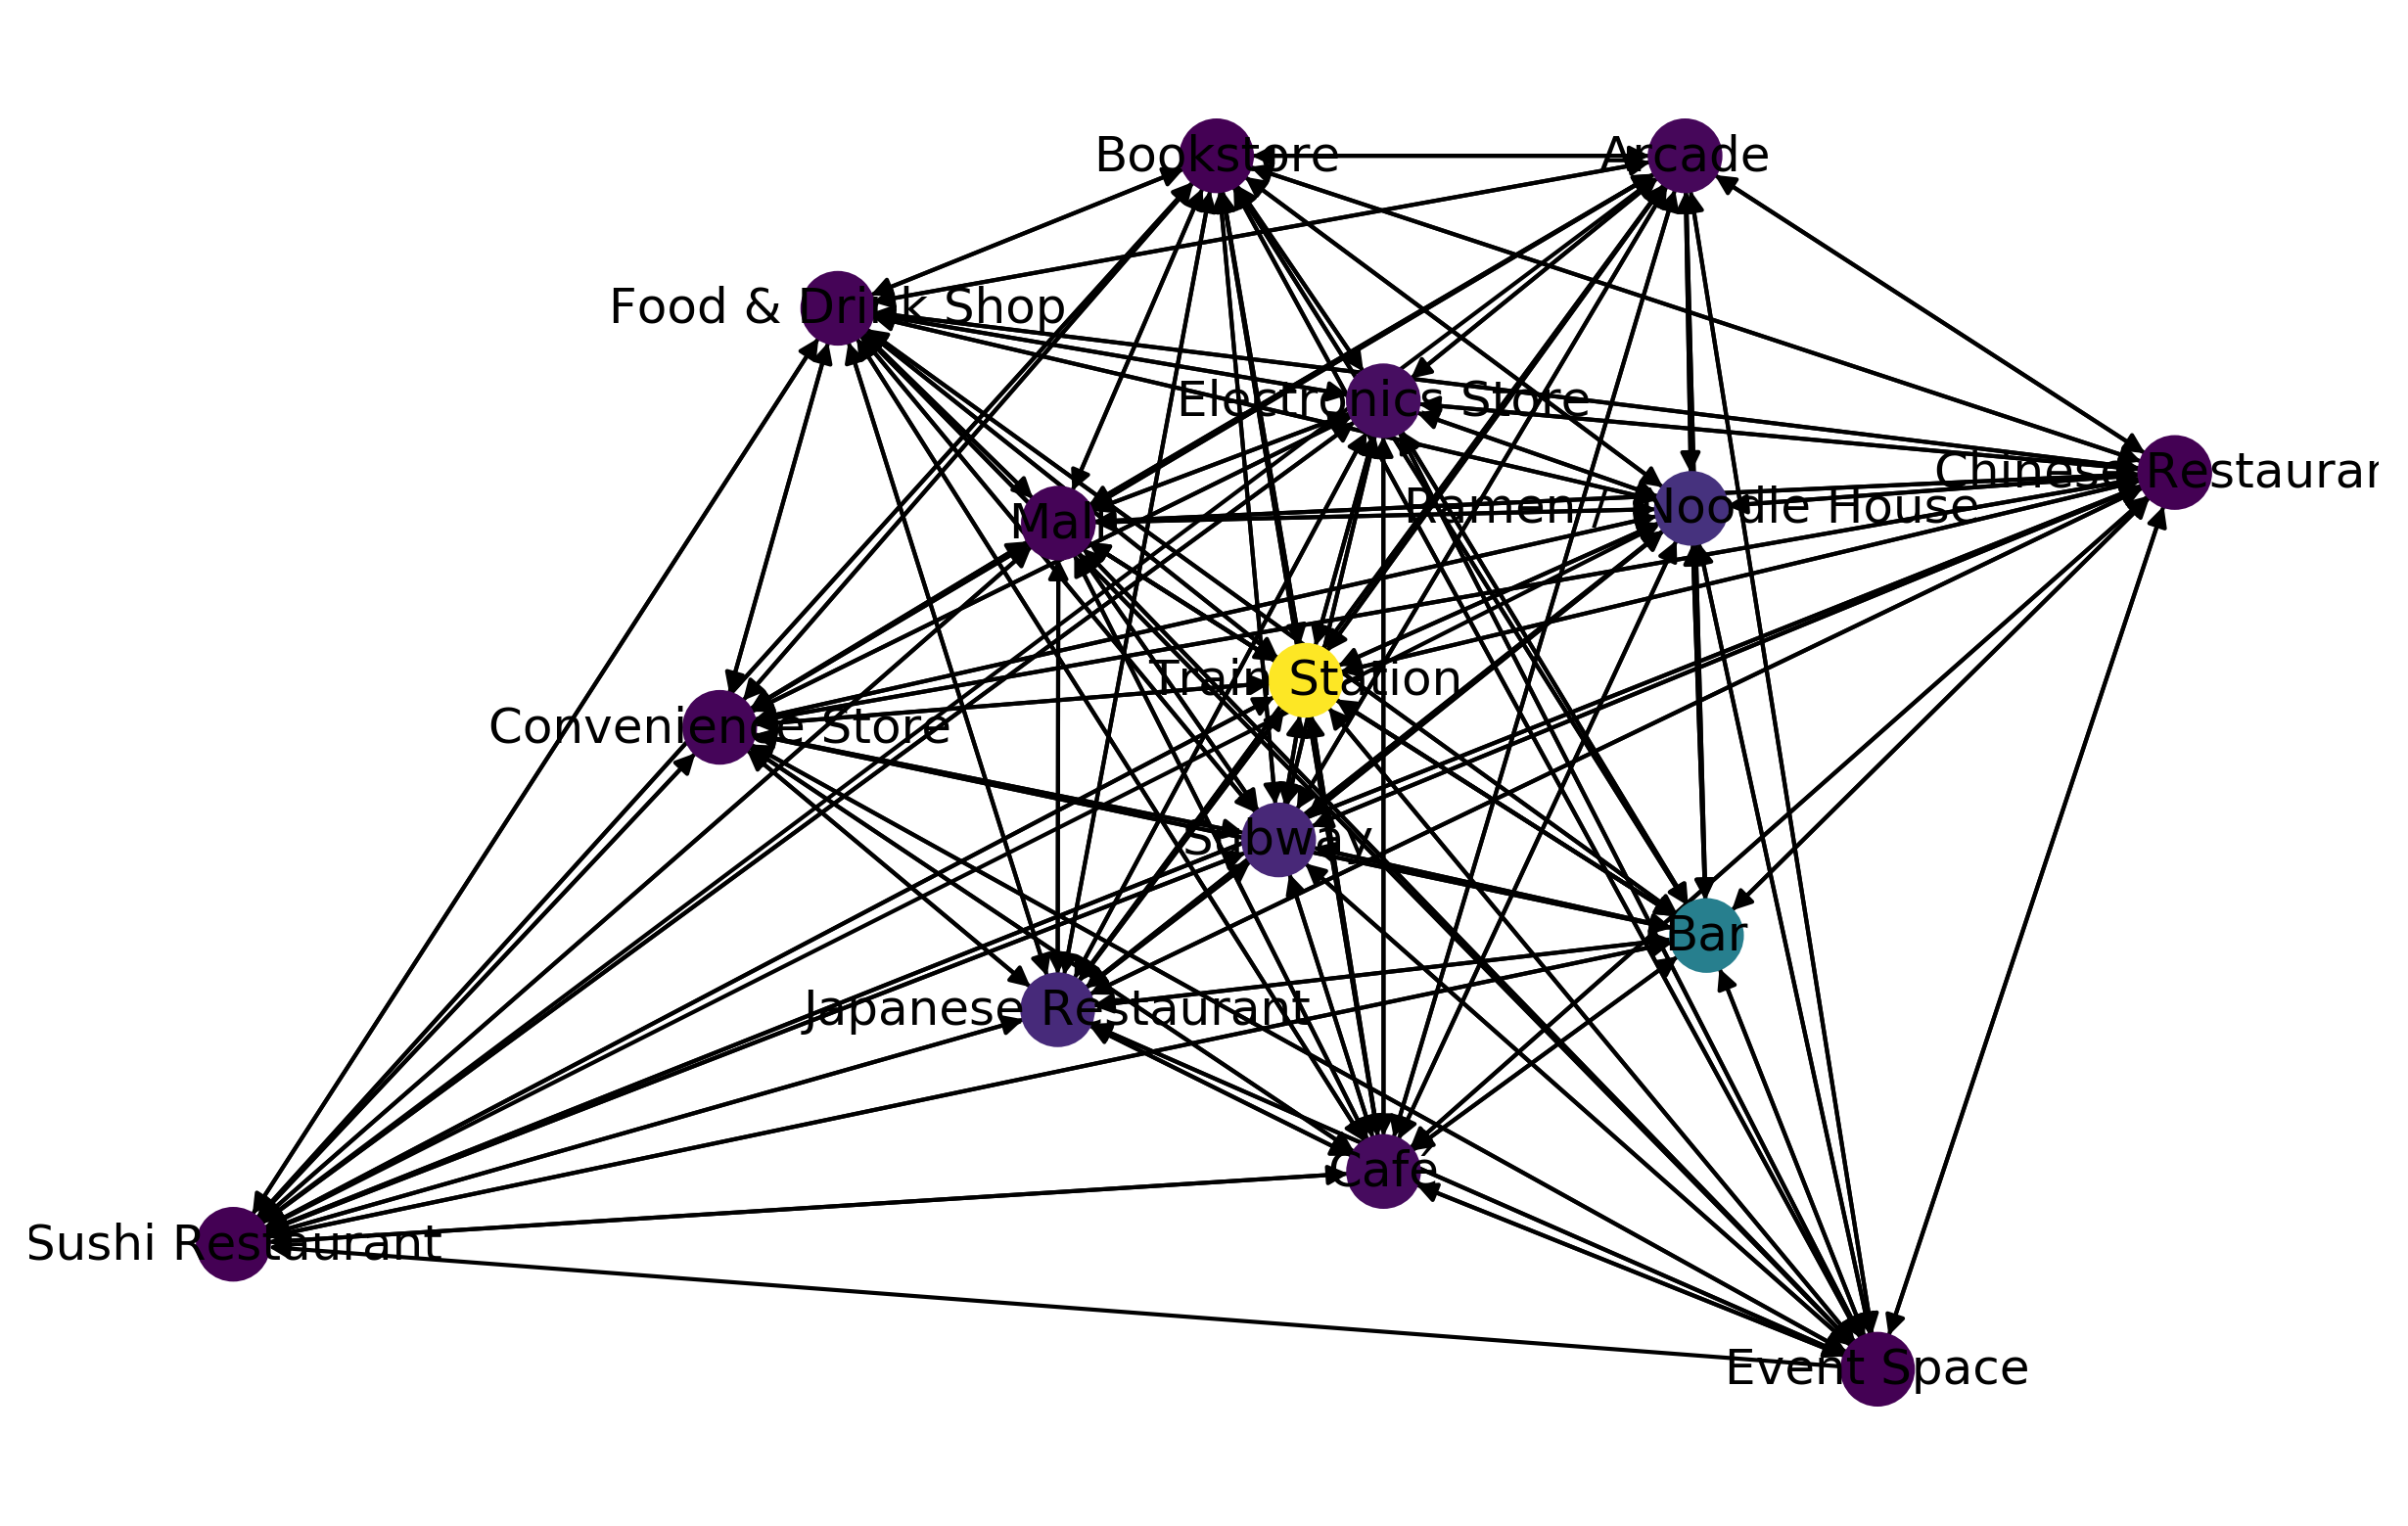

In [291]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=300)
nodes, people = do_spread(cat_g_we, 'Bar')
nx.draw(cat_g_we.subgraph(nodes), nodelist=nodes, node_color=people, with_labels=True)